In [4]:
train_path = './train.parquet'
test_path = './test.parquet'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import get_scheduler

from datetime import datetime, timedelta

from tqdm.auto import tqdm
tqdm.pandas()

/home/ekaterina/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
train_df = pd.read_parquet(train_path)
test_df = pd.read_parquet(test_path)
len(train_df), len(test_df)

(80000, 20000)

Стационарность — одно из важнейших свойств временных рядов. Стационарный ряд — это ряд, в котором статистические характеристики, такие как среднее и дисперсия, остаются постоянными во времени. Это свойство позволяет нам строить надежные модели и прогнозировать будущие значения.

Если p-значение меньше уровня значимости (обычно 0.05), то мы можем отклонить нулевую гипотезу о нестационарности ряда и считать его стационарным.

In [6]:
train_df['new_dates'] = train_df['dates'].progress_apply(lambda x: pd.date_range(start=x.min(), end=x.max(), freq='M'))
test_df['new_dates'] = test_df['dates'].progress_apply(lambda x: pd.date_range(start=x.min(), end=x.max(), freq='M'))

 31%|███▏      | 25136/80000 [00:46<01:41, 538.54it/s] 


KeyboardInterrupt: 

In [ ]:
train_df['new_dates'] = train_df.new_dates.map(lambda x: x.date)
test_df['new_dates'] = test_df.new_dates.map(lambda x: x.date)

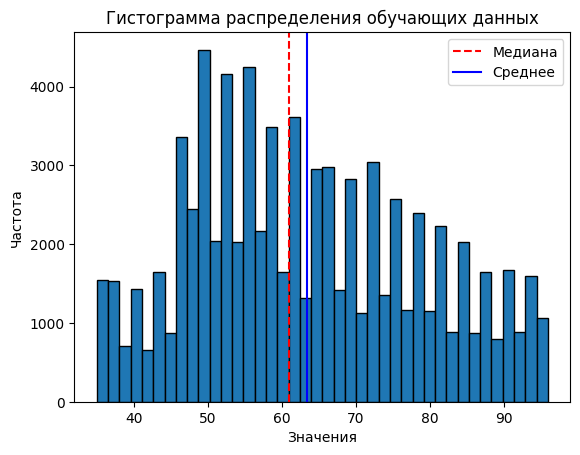

In [ ]:
data = train_df.new_dates.map(len)
plt.hist(data, bins=40, edgecolor='black')
median = np.median(data)
mean = np.mean(data)

plt.axvline(median, color='red', linestyle='--', label='Медиана')
plt.axvline(mean, color='blue', linestyle='-', label='Среднее')
plt.legend()
plt.xlabel("Значения")
plt.ylabel("Частота")
plt.title("Гистограмма распределения обучающих данных")

plt.show()

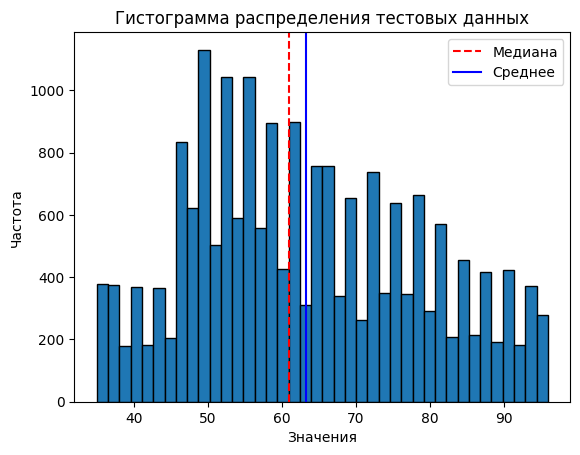

In [ ]:
data = test_df.new_dates.map(len)
plt.hist(data, bins=40, edgecolor='black')
median = np.median(data)
mean = np.mean(data)

plt.axvline(median, color='red', linestyle='--', label='Медиана')
plt.axvline(mean, color='blue', linestyle='-', label='Среднее')
plt.legend()
plt.xlabel("Значения")
plt.ylabel("Частота")
plt.title("Гистограмма распределения тестовых данных")

plt.show()

In [ ]:
median = int(median)

def adjust_dates(dates):
  if len(dates) < median:
    first_date = dates[0]
    dif = median - len(dates)
    for i in range(dif):
      first_date -= timedelta(days=30)
      dates = np.insert(dates, 0, first_date)

  return dates[:median]

In [ ]:
train_df['new_dates'] = train_df['new_dates'].progress_apply(adjust_dates)
test_df['new_dates'] = test_df['new_dates'].progress_apply(adjust_dates)

  0%|          | 0/80000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
def new_values(row):
  return np.interp(row['new_dates'], row['dates'], row['values'])

In [ ]:
train_df['new_dates'] = train_df.new_dates.map(lambda x: pd.DatetimeIndex(x))
train_df['dates'] = train_df.dates.map(lambda x: pd.DatetimeIndex(x))

test_df['new_dates'] = test_df.new_dates.map(lambda x: pd.DatetimeIndex(x))
test_df['dates'] = test_df.dates.map(lambda x: pd.DatetimeIndex(x))

In [ ]:
train_df['new_values'] = train_df.progress_apply(lambda x: new_values(x), axis=1)
test_df['new_values'] = test_df.progress_apply(lambda x: new_values(x), axis=1)

  0%|          | 0/80000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
def count_std(sample):
  return np.sqrt(np.square(sample['new_values'] - sample['mean_values']).sum() / len(sample['new_values']))

train_df['mean_values'] = train_df['new_values'].progress_apply(lambda x: sum(x)/len(x))
train_df['std'] = train_df.progress_apply(lambda x: count_std(x), axis=1)

test_df['mean_values'] = test_df['new_values'].progress_apply(lambda x: sum(x)/len(x))
test_df['std'] = test_df.progress_apply(lambda x: count_std(x), axis=1)

  0%|          | 0/80000 [00:00<?, ?it/s]

  0%|          | 0/80000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
total_mean_train = train_df['mean_values'].mean()
total_std_train = train_df['std'].mean()

total_mean_test = test_df['mean_values'].mean()
total_std_test = test_df['std'].mean()

print("Train/Test mean: ", total_mean_train, total_mean_test)
print("Train/Test std: ", total_std_train, total_std_test)

Train/Test mean:  0.019616169239513544 0.01965484121723822
Train/Test std:  1.1832532777448885 1.1831258001164138


In [ ]:
train_df['min_values'] = train_df.new_values.map(min)
train_df['max_values'] = train_df.new_values.map(max)

test_df['min_values'] = test_df.new_values.map(min)
test_df['max_values'] = test_df.new_values.map(max)

In [ ]:
def min_max_scale(sample):
  return (sample.new_values - sample.min_values) / (sample.max_values - sample.min_values)

In [ ]:
train_df['scaled_values'] = train_df.progress_apply(lambda x: min_max_scale(x), axis=1)
test_df['scaled_values'] = test_df.progress_apply(lambda x: min_max_scale(x), axis=1)

  0%|          | 0/80000 [00:00<?, ?it/s]

<ipython-input-117-ee3faea09b0c>:2: RuntimeWarning: invalid value encountered in divide
  return (sample.new_values - sample.min_values) / (sample.max_values - sample.min_values)


  0%|          | 0/20000 [00:00<?, ?it/s]

<ipython-input-117-ee3faea09b0c>:2: RuntimeWarning: divide by zero encountered in divide
  return (sample.new_values - sample.min_values) / (sample.max_values - sample.min_values)


In [ ]:
train_df['isnan_values'] = train_df['scaled_values'].map(lambda x: np.isnan(x).any()).astype(int)
test_df['isnan_values'] = test_df['scaled_values'].map(lambda x: np.isinf(x).any() or np.isnan(x).any()).astype(int)

In [ ]:
counts = [0] * median
for i, row in tqdm(train_df[train_df['isnan_values'] == 0].iterrows()):
  for j in range(median):
    values = row.scaled_values
    counts[j] += values[j]

0it [00:00, ?it/s]

In [ ]:
def fill_nan(row, fill_array):
  if row.isnan_values == 1:
    return fill_array
  return row.scaled_values

In [ ]:
counts = np.array(counts) / len(train_df[train_df['isnan_values'] == 0])
train_df['scaled_values'] = train_df.progress_apply(lambda x: fill_nan(x, counts), axis=1)

  0%|          | 0/80000 [00:00<?, ?it/s]

In [ ]:
counts_test = [0] * median
for i, row in tqdm(test_df[test_df['isnan_values'] == 0].iterrows()):
  for j in range(median):
    values = row.scaled_values
    counts_test[j] += values[j]

0it [00:00, ?it/s]

In [ ]:
counts_test = np.array(counts_test) / len(test_df[test_df['isnan_values'] == 0])
test_df['scaled_values'] = test_df.progress_apply(lambda x: fill_nan(x, counts_test), axis=1)

  0%|          | 0/20000 [00:00<?, ?it/s]

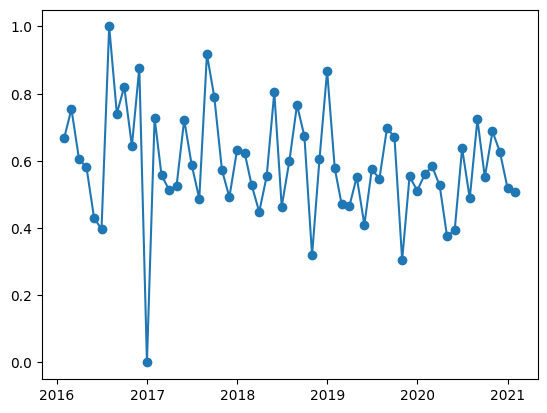

ADF Statistic: -1.234276
p-value: 0.658680
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599


In [298]:
sample = train_df.iloc[0]
plt.plot(sample['new_dates'], sample['scaled_values'], marker='o', linestyle='-')
plt.show()

# Проведем тест Дики-Фуллера на стационарность
result = adfuller(sample['scaled_values'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
train_dataset = Dataset.from_pandas(train_df[['id', 'scaled_values', 'label']])
test_dataset = Dataset.from_pandas(test_df[['id', 'scaled_values']])

train_dataset.set_format(type='pt')
test_dataset.set_format(type='pt')
train_dataset = train_dataset.train_test_split(test_size=0.2)

In [260]:
BATCH_SIZE = 128

In [294]:
train_dataloader = DataLoader(train_dataset['train'], batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(train_dataset['train'], batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [262]:
class Simple1DCNN(nn.Module):
  def __init__(self, input_channels, output_size):
    super(Simple1DCNN, self).__init__()

    self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
    self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)

    self.pool = nn.MaxPool1d(kernel_size=2)

    self.fc1 = nn.Linear(64 * 7, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, output_size)

    self.relu = nn.ReLU()
    self.batch_norm1 = nn.BatchNorm1d(16)
    self.batch_norm2 = nn.BatchNorm1d(32)
    self.batch_norm3 = nn.BatchNorm1d(64)

  def forward(self, x):
    x = x.unsqueeze(1)
    x = self.relu(self.conv1(x))
    x = self.batch_norm1(self.pool(x))

    x = self.relu(self.conv2(x))
    x = self.batch_norm2(self.pool(x))

    x = self.relu(self.conv3(x))
    x = self.batch_norm3(self.pool(x))
    x = x.view(x.size(0), -1)

    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [263]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [258]:
EPOCHS = 100

In [268]:
model = Simple1DCNN(1, 2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

num_training_steps = EPOCHS * len(train_dataloader)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=len(train_dataloader) * 0.5,  # warmup = half an epoch
    num_training_steps=num_training_steps,
)

In [269]:
def train_loop(model, optimizer, scheduler, criterion, train_loader, val_loader, epochs):
  train_losses, val_losses = [], []
  n1, n2 = len(train_loader), len(val_loader)
  for epoch in range(epochs):
    print(f"Epoch {epoch+1}")

    model.train()
    train_loss, train_total = 0, 0
    for batch_idx, batch in enumerate(tqdm(train_loader, leave=False, desc="Обучение")):
      data, target = batch['scaled_values'].to(device), batch['label'].long().to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)

      loss.backward()
      optimizer.step()
      scheduler.step()

      train_loss += loss.item()
      train_losses.append(loss.item())

    model.eval()
    val_loss, val_total = 0, 0
    with torch.no_grad():
      for batch_idx, batch in enumerate(tqdm(val_loader, leave=False, desc="Валидация")):
        data, target = batch['scaled_values'].to(device), batch['label'].long().to(device)
        output = model(data)
        loss = criterion(output, target)

        val_loss += loss.item()
        val_losses.append(loss.item())

    print(f" Train: {train_loss / n1}")
    print(f" Validation: {val_loss / n2}")
  return train_losses, val_losses

In [ ]:
train_losses, val_losses = train_loop(model, optimizer, scheduler, criterion, train_dataloader, val_dataloader, EPOCHS)

In [273]:
# torch.save(model.state_dict(), 'model_dict.pt')
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH, weights_only=True))
# model.eval()

# torch.save(model, "model.pth")
# model = torch.load(PATH, weights_only=False)
# model.eval()

In [352]:
model1 = torch.load('/content/model.pth', weights_only=False)
model1.eval()

Simple1DCNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=448, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (batch_norm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [270]:
# val_correct += (output.argmax(dim=1) == target).sum().item()

In [274]:
from sklearn.metrics import roc_auc_score

In [289]:
model.eval()
total_score = 0
with torch.no_grad():
  for batch_idx, batch in tqdm(enumerate(val_dataloader)):
      data, target = batch['scaled_values'].to(device), batch['label'].long()
      output = model(data)
      predictions = output.argmax(dim=1)
      score = roc_auc_score(target.numpy(), predictions.cpu().detach().numpy())
      total_score += score

0it [00:00, ?it/s]

In [290]:
total_score / len(val_dataloader)

0.9973729366208307

In [292]:
sample = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
sample.head()

,id,score
0,6125.0,0.757097
1,26781.0,0.346173
2,13333.0,0.431305
3,53218.0,0.847472
4,84204.0,0.065298


In [360]:
model1 = model1.cpu()

In [361]:
# model.eval()
total_predictions, ids = [], []
sgm = nn.Sigmoid()
with torch.no_grad():
  for batch_idx, batch in tqdm(enumerate(test_dataloader)):
      data = batch['scaled_values']#.to(device)
      ids = np.append(ids, batch['id'])
      output = sgm(model1(data))
      predictions = output[:, 1]
      total_predictions = np.append(total_predictions, predictions.cpu().detach().numpy())

0it [00:00, ?it/s]

In [346]:
submission = pd.DataFrame({'id': ids, 'score': total_predictions})
submission.to_csv('submission.csv', index=False)